In [116]:
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
import torch
import torch.nn as nn

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

In [117]:
model = AutoModelForSequenceClassification.from_pretrained(
    "lightonai/RITA_s", trust_remote_code=True, num_labels=27
)

tokenizer = AutoTokenizer.from_pretrained("lightonai/RITA_s")

tokenizer.pad_token_id = 1
model.config.pad_token_id = tokenizer.pad_token_id

loading configuration file https://huggingface.co/lightonai/RITA_s/resolve/main/config.json from cache at /Users/maia/.cache/huggingface/transformers/36175bb600af61a7b34fc92d3e2511016a2ffce591c699fa57e43827a2751720.062cec24332a9b831bfb86a7aca88f74a7cf234dd8ea182800473c491780b606
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
loading configuration file https://huggingface.co/lightonai/RITA_s/resolve/main/config.json from cache at /Users/maia/.cache/huggingface/transformers/36175bb600af61a7b34fc92d3e2511016a2ffce591c699fa57e43827a2751720.062cec24332a9b831bfb86a7aca88f74a7cf234dd8ea182800473c491780b606
Model config RITAConfig {
  "_name_or_path": "lightonai/RITA_s",
  "architectures": [
    "RITAModelForCausalLM"
  ],
  "auto_map": {
    "AutoConfig": "rita_configuration.RITAConfig",
    "AutoModel": "rita_modeling.RITAModel",
    "AutoModelForCausalLM": "rita_modeling.RITAMo

## Data Processing

In [4]:
def load_data(raw_data: str = "Sequences.fasta", labelled: bool = True) -> pd.DataFrame:
    if labelled:
        labelled_sequences = [
            {
                "ID": i.id,
                "Group_ID": i.id.split("_")[0],
                "Number_ID": i.id.split("_")[1],
                "Sequence Length": len(i.seq),
                "Sequence": i.seq,
            }
            for i in SeqIO.parse(raw_data, "fasta")
        ]
        print(f"Number of labelled sequences: {len(labelled_sequences)}")
        return pd.DataFrame(labelled_sequences)
    else:
        pred_sequences = [
            {"ID": i.id, "Sequence Length": len(i.seq), "Sequence": i.seq}
            for i in SeqIO.parse(raw_data, "fasta")
        ]
        print(f"Number of pred sequences: {len(pred_sequences)}")
        return pd.DataFrame(pred_sequences)


def create_dataset_split(data_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Splitting dataset, any class with <3 instances added to train_df
    filtered_df = data_df[data_df["Group_ID"].isin(["A", "B", "C"])]
    train_df, eval_df = train_test_split(
        filtered_df, shuffle=True, stratify=filtered_df["Group_ID"]
    )
    train_df = pd.concat(
        [train_df, data_df[~data_df["Group_ID"].isin(["A", "B", "C"])]]
    )
    print(f"Train Dataset Size: {len(train_df)}, Eval Dataset Size: {len(eval_df)}")
    return train_df, eval_df

In [5]:
labelled_df = load_data("Sequences.fasta", labelled=True)
train_df, eval_df = create_dataset_split(labelled_df)
pred_df = load_data("Predictions.fasta", labelled=False)

Number of labelled sequences: 1000
Train Dataset Size: 756, Eval Dataset Size: 244
Number of pred sequences: 10


In [6]:
group_ids = labelled_df["Group_ID"].unique()
group_id_hash = {group_ids[i]: i for i in range(len(group_ids))}

In [111]:
class ProteinDataset(Dataset):
    def __init__(
        self,
        data_df: pd.DataFrame,
        tokenizer,
        group_id_hash: dict,
        mode: str = "train",
        labelled: bool = True,
    ):
        self.data_df = data_df
        self.tokenizer = tokenizer
        self.group_id_hash = group_id_hash
        self.mode = mode
        self.labelled = labelled
        self.max_sequence_length = self.data_df["Sequence Length"].max()
        self.mean_sequence_length = self.data_df["Sequence Length"].mean()
        self._preprocess()

    def summarise_data(self, save_path: str = None) -> None:
        if self.labelled:
            print(self.data_df["Group_ID"].value_counts())
        print(f"Mean Sequence Length: {self.mean_sequence_length}")
        print(f"Max Sequence Length: {self.max_sequence_length}")
        if self.labelled:
            print(f'Number of Protein Groups: {self.data_df["Group_ID"].nunique()}')
        sns.histplot(self.data_df["Sequence Length"])
        if save_path:
            plt.savefig(save_path)

    def _preprocess_function(self, sample):
        return self.tokenizer(
            str(sample),
            padding="max_length",
            max_length=self.max_sequence_length,
            truncation=True,
        )

    def _preprocess(self):
        self.data_df["tokens"] = self.data_df["Sequence"].apply(
            self._preprocess_function
        )

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, idx: int) -> dict:
        sample = self.data_df.iloc[idx]
        tokens = sample["tokens"]

        if self.labelled:
            label = torch.LongTensor([self.group_id_hash[sample["Group_ID"]]])
            return {"label": label, **tokens}
        else:
            return {"id": sample["ID"], **tokens}

In [112]:
train_dataset = ProteinDataset(
    data_df=train_df,
    tokenizer=tokenizer,
    group_id_hash=group_id_hash,
    mode="train",
    labelled=True,
)
eval_dataset = ProteinDataset(
    data_df=eval_df,
    tokenizer=tokenizer,
    group_id_hash=group_id_hash,
    mode="eval",
    labelled=True,
)
pred_dataset = ProteinDataset(
    data_df=pred_df,
    tokenizer=tokenizer,
    group_id_hash=group_id_hash,
    mode="pred",
    labelled=False,
)

## Data Exploration

### Protein Groups

| Protein Group   |      Sequences      |
|----------|:-------------:|
| A |  683 |
| B |  193 |
| C | 99 |
| Other (single instances) | 22 |


### Sequences

#### Labelled
- Mean sequence length: 220.426
- Max sequence length: 422 (<512 so viable as pretrained transformer input)

#### Prediction
- Mean: 183.2
- Max: 277

Mean Sequence Length: 183.2
Max Sequence Length: 277


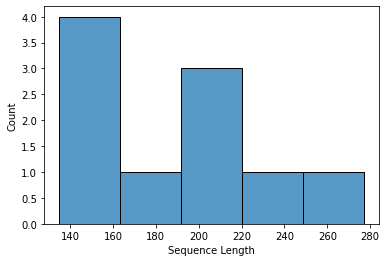

In [113]:
pred_dataset.summarise_data()

A    171
C     48
B     25
Name: Group_ID, dtype: int64
Mean Sequence Length: 222.11065573770492
Max Sequence Length: 404
Number of Protein Groups: 3


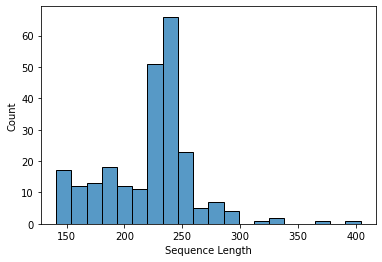

In [114]:
eval_dataset.summarise_data()

A        512
C        145
B         74
P          2
PT         1
CE         1
CC         1
L          1
D          1
HHHH       1
U          1
AA         1
F          1
G          1
ttttt      1
AD         1
ADD        1
M          1
II         1
LL         1
A)         1
A***8      1
AC         1
AV         1
T          1
IA         1
O          1
Name: Group_ID, dtype: int64
Mean Sequence Length: 219.88227513227514
Max Sequence Length: 422
Number of Protein Groups: 27


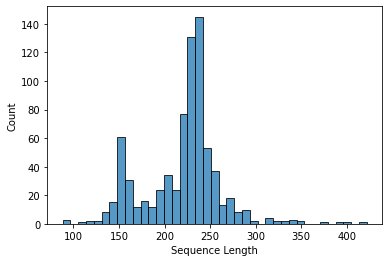

In [115]:
train_dataset.summarise_data(save_path="results/train_sequence_length.png")

## Model

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [14]:
trainer.train()

/Users/maia/miniforge3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 756
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 190


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/190 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 3039.8695, 'train_samples_per_second': 0.497, 'train_steps_per_second': 0.063, 'train_loss': 0.5405931974712171, 'epoch': 2.0}


TrainOutput(global_step=190, training_loss=0.5405931974712171, metrics={'train_runtime': 3039.8695, 'train_samples_per_second': 0.497, 'train_steps_per_second': 0.063, 'train_loss': 0.5405931974712171, 'epoch': 2.0})

In [15]:
torch.save(model.state_dict(), "results/trained_rita.pth")

## Evaluation

In [14]:
model.load_state_dict(torch.load("results/trained_rita.pth"))
model.eval()

RITAModelForSequenceClassification(
  (transformer): RITAModel(
    (embedding): Embedding(26, 768)
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attention): SelfAttention(
          (key): Linear(in_features=768, out_features=768, bias=True)
          (query): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (resid_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (rotary_embedding): RotaryEmbedding()
        )
        (attn_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): RITAGELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (mlp_norm): LayerNor

In [27]:
### RUN EVALUATION
inv_group_id_hash = {val: key for key, val in group_id_hash.items()}
prob_groups = []
pred_groups = []
for i in range(len(eval_dataset)):
    sample = eval_dataset[i]
    output = model(torch.reshape(torch.IntTensor(sample["input_ids"]), (1, -1)))
    assert output.logits.shape == (1, 27)
    probs = nn.functional.softmax(output.logits)
    prob_groups.append(probs.tolist()[0])
    pred_groups.append(inv_group_id_hash[int(probs.argmax())])
    print(
        f'{i} | Sample: {inv_group_id_hash[int(sample["label"])]}, Prediction: {pred_groups[-1]}'
    )

/var/folders/0d/kmj6kw8523x6kfszxm3hmxgm0000gn/T/ipykernel_79295/1044897441.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(output.logits)


0 | Sample: C, Prediction: C
1 | Sample: A, Prediction: A
2 | Sample: B, Prediction: B
3 | Sample: C, Prediction: C
4 | Sample: A, Prediction: A
5 | Sample: B, Prediction: C
6 | Sample: B, Prediction: B
7 | Sample: A, Prediction: A
8 | Sample: A, Prediction: A
9 | Sample: C, Prediction: C
10 | Sample: A, Prediction: A
11 | Sample: A, Prediction: A
12 | Sample: C, Prediction: C
13 | Sample: A, Prediction: A
14 | Sample: C, Prediction: C
15 | Sample: C, Prediction: C
16 | Sample: A, Prediction: A
17 | Sample: A, Prediction: A
18 | Sample: B, Prediction: B
19 | Sample: A, Prediction: A
20 | Sample: A, Prediction: A
21 | Sample: C, Prediction: C
22 | Sample: A, Prediction: A
23 | Sample: A, Prediction: A
24 | Sample: C, Prediction: C
25 | Sample: A, Prediction: A
26 | Sample: C, Prediction: C
27 | Sample: A, Prediction: A
28 | Sample: A, Prediction: A
29 | Sample: A, Prediction: A
30 | Sample: B, Prediction: B
31 | Sample: C, Prediction: C
32 | Sample: A, Prediction: A
33 | Sample: B, Pred

In [39]:
### Save Evaluation Results and Show Errors
eval_dataset.data_df["Group_ID_Predicted"] = pred_groups
eval_dataset.data_df["Predicted_Probabilities"] = prob_groups
eval_dataset.data_df["Correct"] = (
    eval_dataset.data_df["Group_ID"] == eval_dataset.data_df["Group_ID_Predicted"]
)
print(eval_dataset.data_df["Correct"].value_counts())
print(f'Accuracy: {eval_dataset.data_df["Correct"].sum()/len(eval_dataset.data_df)}')
eval_dataset.data_df[eval_dataset.data_df["Correct"] == False]

True     241
False      3
Name: Correct, dtype: int64
Accuracy: 0.9877049180327869


,ID,Group_ID,Number_ID,Sequence Length,Sequence,tokens,Group_ID_Predicted,Predicted_Probabilities,Correct
797,B_098,B,098,164,"(G, S, G, F, I, I, N, D, D, G, Y, A, V, T, N, ...","[input_ids, token_type_ids, attention_mask]",C,"[0.001110101817175746, 0.00020816574397031218,...",False
956,C_157,C,157,192,"(G, S, G, F, I, I, S, N, D, G, L, I, V, T, N, ...","[input_ids, token_type_ids, attention_mask]",B,"[0.0007062445511110127, 0.00018561746401246637...",False
779,B_080,B,080,151,"(G, T, G, F, Y, I, G, S, S, G, W, L, L, T, N, ...","[input_ids, token_type_ids, attention_mask]",C,"[0.001949576078914106, 0.0002489994221832603, ...",False


In [73]:
### Calculate evaluation metrics
for group_class in eval_dataset.data_df["Group_ID"].unique():
    trues = eval_dataset.data_df[(eval_dataset.data_df["Correct"])]
    falses = eval_dataset.data_df[~(eval_dataset.data_df["Correct"])]

    tp = len(trues[trues["Group_ID"] == group_class])
    fp = len(falses[falses["Group_ID_Predicted"] == group_class])
    tn = len(trues[trues["Group_ID_Predicted"] != group_class])
    fn = len(falses[falses["Group_ID"] == group_class])
    acc = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    print(
        f"Group: {group_class}, Accuracy: {acc:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, Specificity: {specificity:.3f}, FPR: {fpr:.3f}"
    )

Group: C, Accuracy: 0.988, Recall: 0.979, Precision: 0.959, Specificity: 0.990, FPR: 0.010
Group: A, Accuracy: 1.000, Recall: 1.000, Precision: 1.000, Specificity: 1.000, FPR: 0.000
Group: B, Accuracy: 0.988, Recall: 0.920, Precision: 0.958, Specificity: 0.995, FPR: 0.005


In [84]:
pred_dataset.data_df

,ID,Sequence Length,Sequence,tokens
0,01,154,"(G, S, G, V, I, V, S, P, E, G, H, V, I, T, N, ...","[input_ids, token_type_ids, attention_mask]"
1,02,221,"(I, V, N, G, K, I, S, T, L, G, E, Y, P, F, M, ...","[input_ids, token_type_ids, attention_mask]"
2,03,135,"(L, V, Y, L, K, S, H, F, N, P, C, V, G, V, L, ...","[input_ids, token_type_ids, attention_mask]"
3,04,277,"(G, T, G, F, I, N, D, K, N, N, G, Y, I, I, T, ...","[input_ids, token_type_ids, attention_mask]"
4,05,201,"(G, S, A, F, F, I, S, K, D, G, Y, L, L, T, N, ...","[input_ids, token_type_ids, attention_mask]"
5,06,138,"(S, G, F, V, S, A, P, D, Y, V, V, T, N, A, H, ...","[input_ids, token_type_ids, attention_mask]"
6,07,199,"(G, T, G, F, F, I, T, K, D, G, Y, V, L, T, N, ...","[input_ids, token_type_ids, attention_mask]"
7,08,179,"(G, S, G, V, I, I, S, K, D, G, Y, I, V, T, N, ...","[input_ids, token_type_ids, attention_mask]"
8,09,136,"(G, F, V, V, D, A, E, R, G, Y, I, L, T, N, R, ...","[input_ids, token_type_ids, attention_mask]"
9,10,192,"(S, G, V, L, V, G, P, H, H, I, L, T, A, A, H, ...","[input_ids, token_type_ids, attention_mask]"


## Predictions

In [108]:
### Make predictions
inv_group_id_hash = {val: key for key, val in group_id_hash.items()}
prob_groups = []
pred_groups = []
for i in range(len(pred_dataset)):
    sample = pred_dataset[i]
    output = model(torch.reshape(torch.IntTensor(sample["input_ids"]), (1, -1)))
    assert output.logits.shape == (1, 27)
    probs = nn.functional.softmax(output.logits)
    prob_groups.append(
        {
            key: val.item()
            for key, val in zip(list(group_id_hash.keys()), list(probs)[0])
        }
    )
    pred_groups.append(inv_group_id_hash[int(probs.argmax())])
    print(f'{sample["id"]} | Prediction: {pred_groups[-1]}')

/var/folders/0d/kmj6kw8523x6kfszxm3hmxgm0000gn/T/ipykernel_79295/4142473098.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(output.logits)


01 | Prediction: C
02 | Prediction: A
03 | Prediction: A
04 | Prediction: C
05 | Prediction: B
06 | Prediction: B
07 | Prediction: B
08 | Prediction: B
09 | Prediction: C
10 | Prediction: A


In [109]:
pred_dataset.data_df["Group_ID_Predicted"] = pred_groups
pred_dataset.data_df["Predicted_Probabilities"] = prob_groups
pred_dataset.data_df.to_csv("results/rita_predictions.csv")